## Load Data

In [1]:
data_path = '../data/'

In [2]:
label_path = '../labels.csv'

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
#os.environ["CUDA_DEVICE_ORDER"] = ""

In [4]:
import glob

In [5]:
filelist = glob.glob(os.path.join(data_path, '*.Bmp'))

In [6]:
file = glob.glob(os.path.join(data_path, '2290.Bmp'))

In [7]:
file

['../data/2290.Bmp']

In [8]:
import re

In [9]:
data_labels = pd.read_csv(label_path)

In [10]:
data_labels[data_labels.ID==int(re.findall('\d+', file[0])[0])].Class.iloc[0]

'q'

In [11]:
# resize images and convert images to arrays, meanwhile load their labels. Convert graylevel images to 3 channels.
data_X = []
data_y = []
flag = 25
for i, fname in enumerate(filelist):
    if i==flag:
        img = Image.open(fname)
        print(data_labels[data_labels.ID==int(re.findall('\d+', fname)[0])].Class.iloc[0])
    data_y.append(data_labels[data_labels.ID==int(re.findall('\d+', fname)[0])].Class.iloc[0])
    img_arr = np.array(Image.open(fname).resize((28,28), Image.NEAREST))
#    print(img_arr.shape)
    if len(img_arr.shape)==2:
        img_arr = np.stack((img_arr,)*3, -1)
    data_X.append(img_arr)

r


In [12]:
img

## Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=None, stratify = data_y, shuffle = True)

In [15]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=None, stratify = train_y, shuffle = True)

In [16]:
train_X = np.array(train_X)
val_X = np.array(val_X)
test_X = np.array(test_X)
train_y = np.squeeze(np.array(train_y))
val_y = np.squeeze(np.array(val_y))
test_y = np.squeeze(np.array(test_y))
y_true = test_y

In [17]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(4020, 28, 28, 3)
(4020,)
(1006, 28, 28, 3)
(1006,)
(1257, 28, 28, 3)
(1257,)


## One-hot encode labels

In [18]:
def label_map_generator(labels):
    label2int = {}
    int2label = []
    set_labels = list(set(labels))
    for i in range(len(set_labels)):
        label2int[set_labels[i]] = i
    for i in label2int.keys():
        int2label.append(i)
    return label2int, int2label

In [19]:
label2int, int2label = label_map_generator(train_y)

### training set

In [20]:
train_y = [label2int[item] for item in train_y]

In [21]:
num_classes = len(set(train_y))

In [22]:
import keras

Using TensorFlow backend.


In [23]:
train_y = keras.utils.to_categorical(train_y, num_classes)

In [24]:
train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### validation set

In [25]:
val_y.shape

(1006,)

In [26]:
val_y = [label2int[item] for item in val_y]

In [27]:
np.array(val_y).shape

(1006,)

In [28]:
val_y = keras.utils.to_categorical(val_y, num_classes)

In [29]:
val_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Build Neural Network

In [30]:
train_X.shape

(4020, 28, 28, 3)

In [31]:
batch_size = 128
#num_classes = 10
epochs = 200

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
metrics=['accuracy'])

#model.summary()
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [34]:
train_X = train_X.astype('float32')
val_X = val_X.astype('float32')

In [35]:
val_y.shape

(1006, 62)

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [37]:
history = model.fit(train_X, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(val_X, val_y))

Train on 4020 samples, validate on 1006 samples
Epoch 1/200
4020/4020 [==============================] - 8s - loss: 15.3823 - acc: 0.0383 - val_loss: 15.4561 - val_acc: 0.0408
Epoch 2/200
4020/4020 [==============================] - 0s - loss: 15.3556 - acc: 0.0400 - val_loss: 15.1814 - val_acc: 0.0467
Epoch 3/200
4020/4020 [==============================] - 0s - loss: 15.2792 - acc: 0.0425 - val_loss: 15.3752 - val_acc: 0.0447
Epoch 4/200
4020/4020 [==============================] - 0s - loss: 15.3900 - acc: 0.0423 - val_loss: 15.3971 - val_acc: 0.0447
Epoch 5/200
4020/4020 [==============================] - 0s - loss: 15.3518 - acc: 0.0445 - val_loss: 15.3971 - val_acc: 0.0447
Epoch 6/200
4020/4020 [==============================] - 0s - loss: 15.3197 - acc: 0.0453 - val_loss: 15.3971 - val_acc: 0.0447
Epoch 7/200
4020/4020 [==============================] - 0s - loss: 15.3464 - acc: 0.0410 - val_loss: 15.1957 - val_acc: 0.0398
Epoch 8/200
4020/4020 [==============================] -

4020/4020 [==============================] - 0s - loss: 1.2921 - acc: 0.6388 - val_loss: 2.4164 - val_acc: 0.4911
Epoch 64/200
4020/4020 [==============================] - 0s - loss: 1.2681 - acc: 0.6480 - val_loss: 2.4140 - val_acc: 0.4861
Epoch 65/200
4020/4020 [==============================] - 0s - loss: 1.1948 - acc: 0.6689 - val_loss: 2.4060 - val_acc: 0.4950
Epoch 66/200
4020/4020 [==============================] - 0s - loss: 1.1948 - acc: 0.6637 - val_loss: 2.3948 - val_acc: 0.4920
Epoch 67/200
4020/4020 [==============================] - 0s - loss: 1.1355 - acc: 0.6836 - val_loss: 2.3982 - val_acc: 0.4940
Epoch 68/200
4020/4020 [==============================] - 0s - loss: 1.1374 - acc: 0.6821 - val_loss: 2.4175 - val_acc: 0.4920
Epoch 69/200
4020/4020 [==============================] - 0s - loss: 1.0585 - acc: 0.6988 - val_loss: 2.4209 - val_acc: 0.4940
Epoch 70/200
4020/4020 [==============================] - 0s - loss: 1.0827 - acc: 0.6928 - val_loss: 2.3765 - val_acc: 0.49

4020/4020 [==============================] - 0s - loss: 0.3417 - acc: 0.9007 - val_loss: 2.8690 - val_acc: 0.5457
Epoch 128/200
4020/4020 [==============================] - 0s - loss: 0.3393 - acc: 0.9005 - val_loss: 2.7490 - val_acc: 0.5487
Epoch 129/200
4020/4020 [==============================] - 0s - loss: 0.3236 - acc: 0.9045 - val_loss: 2.6153 - val_acc: 0.5507
Epoch 130/200
4020/4020 [==============================] - 0s - loss: 0.3124 - acc: 0.9100 - val_loss: 2.5259 - val_acc: 0.5487
Epoch 131/200
4020/4020 [==============================] - 0s - loss: 0.3265 - acc: 0.9057 - val_loss: 2.6882 - val_acc: 0.5437
Epoch 132/200
4020/4020 [==============================] - 0s - loss: 0.3334 - acc: 0.9032 - val_loss: 2.5995 - val_acc: 0.5517
Epoch 133/200
4020/4020 [==============================] - 0s - loss: 0.2934 - acc: 0.9144 - val_loss: 2.6290 - val_acc: 0.5557
Epoch 134/200
4020/4020 [==============================] - 0s - loss: 0.3320 - acc: 0.9035 - val_loss: 2.7143 - val_ac

4020/4020 [==============================] - 0s - loss: 0.1782 - acc: 0.9515 - val_loss: 2.7010 - val_acc: 0.5696
Epoch 192/200
4020/4020 [==============================] - 0s - loss: 0.1892 - acc: 0.9498 - val_loss: 2.8330 - val_acc: 0.5706
Epoch 193/200
4020/4020 [==============================] - 0s - loss: 0.1626 - acc: 0.9522 - val_loss: 2.8516 - val_acc: 0.5755
Epoch 194/200
4020/4020 [==============================] - 0s - loss: 0.1814 - acc: 0.9483 - val_loss: 3.1720 - val_acc: 0.5636
Epoch 195/200
4020/4020 [==============================] - 0s - loss: 0.1865 - acc: 0.9485 - val_loss: 2.8574 - val_acc: 0.5557
Epoch 196/200
4020/4020 [==============================] - 0s - loss: 0.1943 - acc: 0.9460 - val_loss: 2.5967 - val_acc: 0.5616
Epoch 197/200
4020/4020 [==============================] - 0s - loss: 0.1640 - acc: 0.9535 - val_loss: 3.2930 - val_acc: 0.5706
Epoch 198/200
4020/4020 [==============================] - 0s - loss: 0.1706 - acc: 0.9490 - val_loss: 2.8866 - val_ac

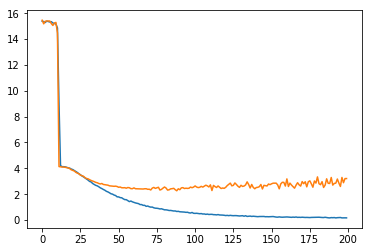

In [38]:
plt.show(plt.plot(history.history['loss']), plt.plot(history.history['val_loss']))

## Evaluate Neural Network with Test Data

In [39]:
y_true

array(['n', 'U', '5', ..., 'Q', 'H', 'A'], dtype='<U1')

In [40]:
y_pred = model.predict_classes(test_X)

1216/1257 [============================>.] - ETA: 0s

In [42]:
y_pred = [int2label[item] for item in y_pred]

In [45]:
list(y_pred == y_true).count(True)

733

In [47]:
len(y_true)

1257

In [63]:
from sklearn.metrics import accuracy_score

In [64]:
accuracy_score(y_true, y_pred)

0.9697619047619047